# Benchmark: MBR computation

Benchmark comparing Minimum Bounding Rectangle computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the Minimum Bounding Rectangle of the multi-polygon representing all districts of India a 100,000 times.

## WARNING

The analysis below shows that GEOS precomputes envolveop and is therefore faster...

# Prerequisites

Generate data:

```sh
cd harness
cargo run --release --bin benchmark_mbr -- --out-file ../analysis/benchmark_mbr/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson --iterations 100 --headlong
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_mbr/data.json
### Statistics: Raw data
                 qps                                            
program          geo         geos   geos_twice geos_twice_cloned
count      80.000000    80.000000    80.000000         80.000000
mean     5001.093088  3553.363412  1801.346631       1806.610381
std      1152.901278   912.584903   456.432422        445.326905
min      2263.666643  1499.611907   883.187712        969.364467
25%      5141.155436  3400.156566  1789.903240       1769.271412
50%      5626.924304  4061.743018  2053.053413       2057.020107
75%      5714.516274  4117.976835  2083.268989       2082.872944
max      5743.204719  4200.488122  2107.212387       2105.840415


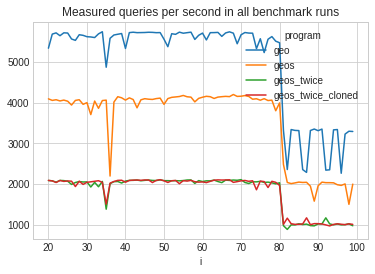

### Statistics: After outlier removal
                 qps                                            
program          geo         geos   geos_twice geos_twice_cloned
count      72.000000    72.000000    72.000000         72.000000
mean     5270.709806  3736.719680  1889.358318       1891.154087
std       848.849036   761.987687   390.700797        384.213970
min      3226.740187  1946.778294   973.201085        999.495358
25%      5466.480959  3958.372714  2013.889962       2017.736467
50%      5659.380766  4070.247410  2060.585562       2064.130634
75%      5717.415384  4131.207885  2084.218886       2087.104069
max      5743.204719  4200.488122  2107.212387       2105.840415


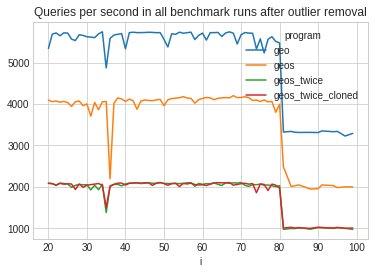

## Ratio of qps compared to geo
               qps                             
program       geos geos_twice geos_twice_cloned
count    72.000000  72.000000         72.000000
mean      0.703652   0.354851          0.355411
std       0.060659   0.026355          0.023833
min       0.393263   0.283518          0.301500
25%       0.707734   0.357796          0.355275
50%       0.719033   0.363574          0.364716
75%       0.728949   0.366757          0.367157
max       0.833947   0.390702          0.393629


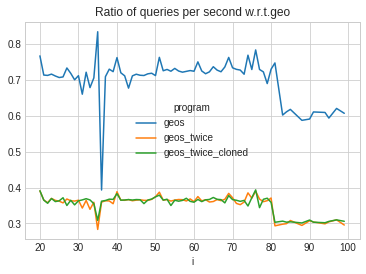

In [1]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb

# Performance benchmarking

To generate the following SVG:

```bash
cd harness
cargo build --release

perf record -F 100 -g --call-graph dwarf -o ../analysis/benchmark_mbr/perf.data -- ./target/release/benchmark_mbr --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 10 --headlong >/dev/null

cd ../analysis/benchmark_mbr
perf script -i perf.data | ../../third_party/stackcollapse-perf.pl > perf.collapsed-stacks.data
../../third_party/flamegraph.pl perf.collapsed-stacks.data > perf.svg
```

![](./perf.svg)

To dig in further, use
```
perf report -g -i perf.data
```

This shows that over 90% time is spent in `geo_types::private_utils::get_bounding_rect`.

In particular, `getEnvelope` in `libgeos` contributes ~0.13% time: ![](./ReportGetEnvelope.png)

-> My assumption that geo is losing out due to bad memory allocations is wrong.

## It's all just destructors

I didn't hvae geos with debugging information. Much better flamegraph once we have that:
 
![](./perf2.svg)

But somehow, geos became **slower** than geo. (should retry without debugsyms again) Verified that geos is still built with `-O2`.

Also, all the time being measured in geos is just destructors. See `./perf.hist.0`.

![](./only-distructors.png)


# gdb

Verified with gdb that:

* computeEnvelopeInternal is hit _before_ measurement, and never during measurement.
* It is hit when I compute the envelope to print it out.
  * It seems that the cached envelope is cloned with `Clone`. Kind of expected in retrospect, eh?


Next things to try:
* Tweak harness so that the variables are not dropped during measurement.
* Tweak benchmark_mbr so that it `Clone`s **before** computing envelope.
  * Verify with gdb that computeEnvelopeInternal is hit in the measurement.

![](./envelope_outside_harness.png)


# No more destructors

After ensuring that values aren't dropped while being measured:

* QPS doubled for all
* runtime ratio stayed unchanged
* callgraphs look better:
![](./NoMoreDestruction.png)
